# **Выбор моделей и работа с признаками**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Код для получения пути к файлам в Kaggle

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [ ]:
%pip install numpy==1.26.4 pandas==2.1.4 scikit-learn==1.7.0 statsmodels==0.14.4 matplotlib==3.8.0 seaborn==0.13.2  nltk==3.9.1 missingno==0.5.2 mlxtend==0.23.4

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [1]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'statsmodels': '0.14.4',
    'matplotlib': '3.8.0',
    'seaborn': '0.13.2',
    'nltk': '3.9.1',
    'missingno': '0.5.2',
    'mlxtend': '0.23.4'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.11.9       | ✓
numpy           | 1.26.4       | 1.26.4       | ✓
pandas          | 2.1.4        | 2.1.4        | ✓
scikit-learn    | 1.7.0        | 1.7.0        | ✓
statsmodels     | 0.14.4       | 0.14.4       | ✓
matplotlib      | 3.8.0        | 3.8.0        | ✓
seaborn         | 0.13.2       | 0.13.2       | ✓
nltk            | 3.9.1        | 3.9.1        | ✓
missingno       | 0.5.2        | 0.5.2        | ✓
mlxtend         | 0.23.4       | 0.23.4       | ✓

Результат проверки:  ✓
Все версии соответствуют требованиям


## **Импорт библиотек и вспомогательные функции**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from mlxtend.evaluate import bias_variance_decomp
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, roc_auc_score, f1_score, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.weightstats import ttest_ind

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords

In [4]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [5]:
RANDOM_STATE = 42

In [6]:
def metrics_report(y_true, y_pred):
    """
    Выводит отчёт с основными метриками качества регрессии.
    Округляет до 4-х знаков после запятой и выводит значения R2 (коэффициент детерминации), RMSE (среднеквадратичная ошибка) и MAPE (средняя абсолютная процентная ошибка) для оценки качества предсказаний.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
    """
    print(f'R2 score: {r2_score(y_true, y_pred):.4f}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5:.4f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}')

### **Обработка пропущенных значений**

**Пропуски в данных (NaN, NULL)** — это незаполненные, пустые ячейки в данных, наличие которых влечет за собой множество проблем, включая искажение данных и снижение качества моделей машинного обучения. 

**Методы обработки пропусков:**

* Удаление пропусков:

    * Удаление строк — удаление всех строк, содержащих хотя бы один пропуск.

    * Удаление столбцов — удаление столбцов (переменных), имеющих большое число пропусков (к примеру, более 50%).

* Заполнение константами:

    * Заполнение числовыми данными — 0, -1, 9999.

    * Заполнение категориальными данными — 'NaN', 'Missing'.

* Добавление бинарного признака — индикатора пропуска.

* Предсказание пропусков (импутация, imputation):

    * Заполнение средним/медианой (числовые данные) или модой (категориальные данные).

    * Заполнение случайным значением из распределения.

    * Заполнение с помощью прогноза моделей (KNN, Random Forest, MICE).

Пропуски в данных могут возникать по разным причинам, и от этого зависит, какой метод обработки будет наиболее эффективным. Выделяют **три основных типа пропусков**:

* MCAR (Missing Completely At Random) — пропуски полностью случайны.

    * Удаление строк (если пропусков мало).

    * Заполнение средним/медианой/модой (если пропусков много).

    * Множественная импутация (MICE, KNN, Random Forest).

* MAR (Missing At Random) – пропуски случайны, но зависят от других наблюдаемых данных.

    * Условное заполнение по группам.

    * Добавление бинарного признака.

    * Множественная импутация (MICE, KNN, Random Forest).

* MNAR (Missing Not At Random) – пропуски неслучайны и зависят от ненаблюдаемых факторов.

    * Сбор дополнительных данных (если существует возможность).

    * Модели с учётом MNAR (к примеру, Heckman correction).

    * Множественная импутация с помощью более сложных моделей (к примеру, Deep Learning с учётом пропусков).

*Выше перечислены основные методы обработки пропущенных значений. На практике количество существующих методов больше, а их применение **зависит от задачи***.

### **Датасет *Life Expectancy (WHO)***

**Для решения заданий 1 — 3 рассмотрим датасет [Life Expectancy (WHO)](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who).**

**ВНИМАНИЕ:** При решении заданий **используйте файл life_expectancy.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Рассмотрим набор данных для прогнозирования ожидаемой продолжительности жизни в 193-x странах за несколько лет. Датасет предназначен для выявления ключевых демографических, экономических и социальных факторов, которые в наибольшей степени влияют на показатель продолжительности жизни.

Одной из особенностей датасета является наличие **большого числа пропущенных значений**, которые необходимо обработать.

Целевая переменная — life expectancy (ожидаемая продолжительность жизни в годах).

Датасет содержит 2938 наблюдений за период с 2000 по 2015 год для 193-x стран и 18 признаков, включая демографические показатели, показатели смертности, экономические показатели, показатели здоровья и др.

### ***Задание 1***

Из исходного набора данных удалите строки с пропусками в целевой переменной и разделите датасет на обучающую и тестовую выборки так, чтобы **в тестовую выборку вошли все данные за 2012-2015 год**.

Выполните анализ пропущенных значений **в обучающей выборке**:

1. Посчитайте доли пропусков в каждой переменной с пропусками.

2. Выполните визуальный анализ пропущенных значений с помощью библиотеки missingno: [bar](https://github.com/ResidentMario/missingno?tab=readme-ov-file#bar), [matrix](https://github.com/ResidentMario/missingno?tab=readme-ov-file#matrix), [heatmap](https://github.com/ResidentMario/missingno?tab=readme-ov-file#heatmap).

3. Выполните статистическую проверку пропусков на MCAR (см. далее).

Для статистической проверки пропусков в факторе (predictor) на MCAR (полностью случайные пропуски) предлагается провести t-тест на наличие статистически значимой разницы в среднем значении целевой переменной (life expectancy) в группе с пропущенными значениями и в группе без пропусков.

**Процедура проверки:**

1. Выбирается признак для проверки на MCAR (predictor).

2. Выборка делится на две группы: только с пропущенными значениями predictor и очищенная от всех пропусков predictor.

3. Выполняется t-тест на статистическую разницу средних целевой переменной (feature) в двух группах:

    * $H_0$: Средние значения feature в обеих группах равны. Пропуски в predictor не связаны со значениями feature (MCAR).

    * $H_1$: Средние значения feature в двух группах различаются. Существует связь пропусков в predictor со значениями feature (MAR или MNAR).

Реализуйте предложенную процедуру проверки признаков на MCAR, дополнив функцию mcar_test.

Для каждого признака с пропусками **на обучающей выборке** выполните статистическую проверку пропущенных значений на принадлежность к типу MCAR (функция mcar_test) **на уровне значимости 1%**.

In [160]:
# Считайте набор данных

df_life = pd.read_csv('life_expectancy.csv')
df_life

,country,year,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis B,measles,BMI,under-five deaths,polio,total expenditure,diphtheria,HIV/AIDS,GDP,population,income composition of resources,schooling
0,Afghanistan,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,0.479,10.1
1,Afghanistan,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,0.476,10.0
2,Afghanistan,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,0.470,9.9
3,Afghanistan,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,0.463,9.8
4,Afghanistan,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,12777511.0,0.407,9.2
2934,Zimbabwe,2003,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,12633897.0,0.418,9.5
2935,Zimbabwe,2002,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,125525.0,0.427,10.0
2936,Zimbabwe,2001,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,12366165.0,0.427,9.8


In [161]:
# В методе info отображается количество непустых наблюдений для каждого из признаков 

df_life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   life expectancy                  2928 non-null   float64
 3   adult mortality                  2928 non-null   float64
 4   infant deaths                    2938 non-null   int64  
 5   alcohol                          2744 non-null   float64
 6   percentage expenditure           2938 non-null   float64
 7   hepatitis B                      2385 non-null   float64
 8   measles                          2938 non-null   int64  
 9   BMI                              2904 non-null   float64
 10  under-five deaths                2938 non-null   int64  
 11  polio                            2919 non-null   float64
 12  total expenditure   

In [162]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)
# year — количественная переменная

s = list(df_life.select_dtypes(exclude=['object']).columns)
s.remove('life expectancy')

life_num_feat = s
life_cat_feat = list(df_life.select_dtypes(include=['object']).columns)

In [163]:
# Удалите строки с пропусками в целевой переменной

df_life = df_life.dropna(subset=['life expectancy'])
df_life.shape

(2928, 19)

In [164]:
# Разделите датасет на обучающую и тестовую выборки так, чтобы в тестовую выборку вошли все данные за 2012-2015 год
# Выделять целевой признак в отдельную переменную не требуется

life_train = df_life[df_life['year'] < 2012]
life_test = df_life[df_life['year'] >= 2012]

In [165]:
# Посчитайте доли пропусков в обучающей выборке

life_nan_info = pd.DataFrame({'NaN share': life_train.isnull().mean()})
life_nan_info = life_nan_info[life_nan_info['NaN share'] != 0.0]

#### [bar](https://github.com/ResidentMario/missingno?tab=readme-ov-file#bar)

Визуализация количества отсутствующих данных по столбцам в виде столбчатой диаграммы.

<Axes: >

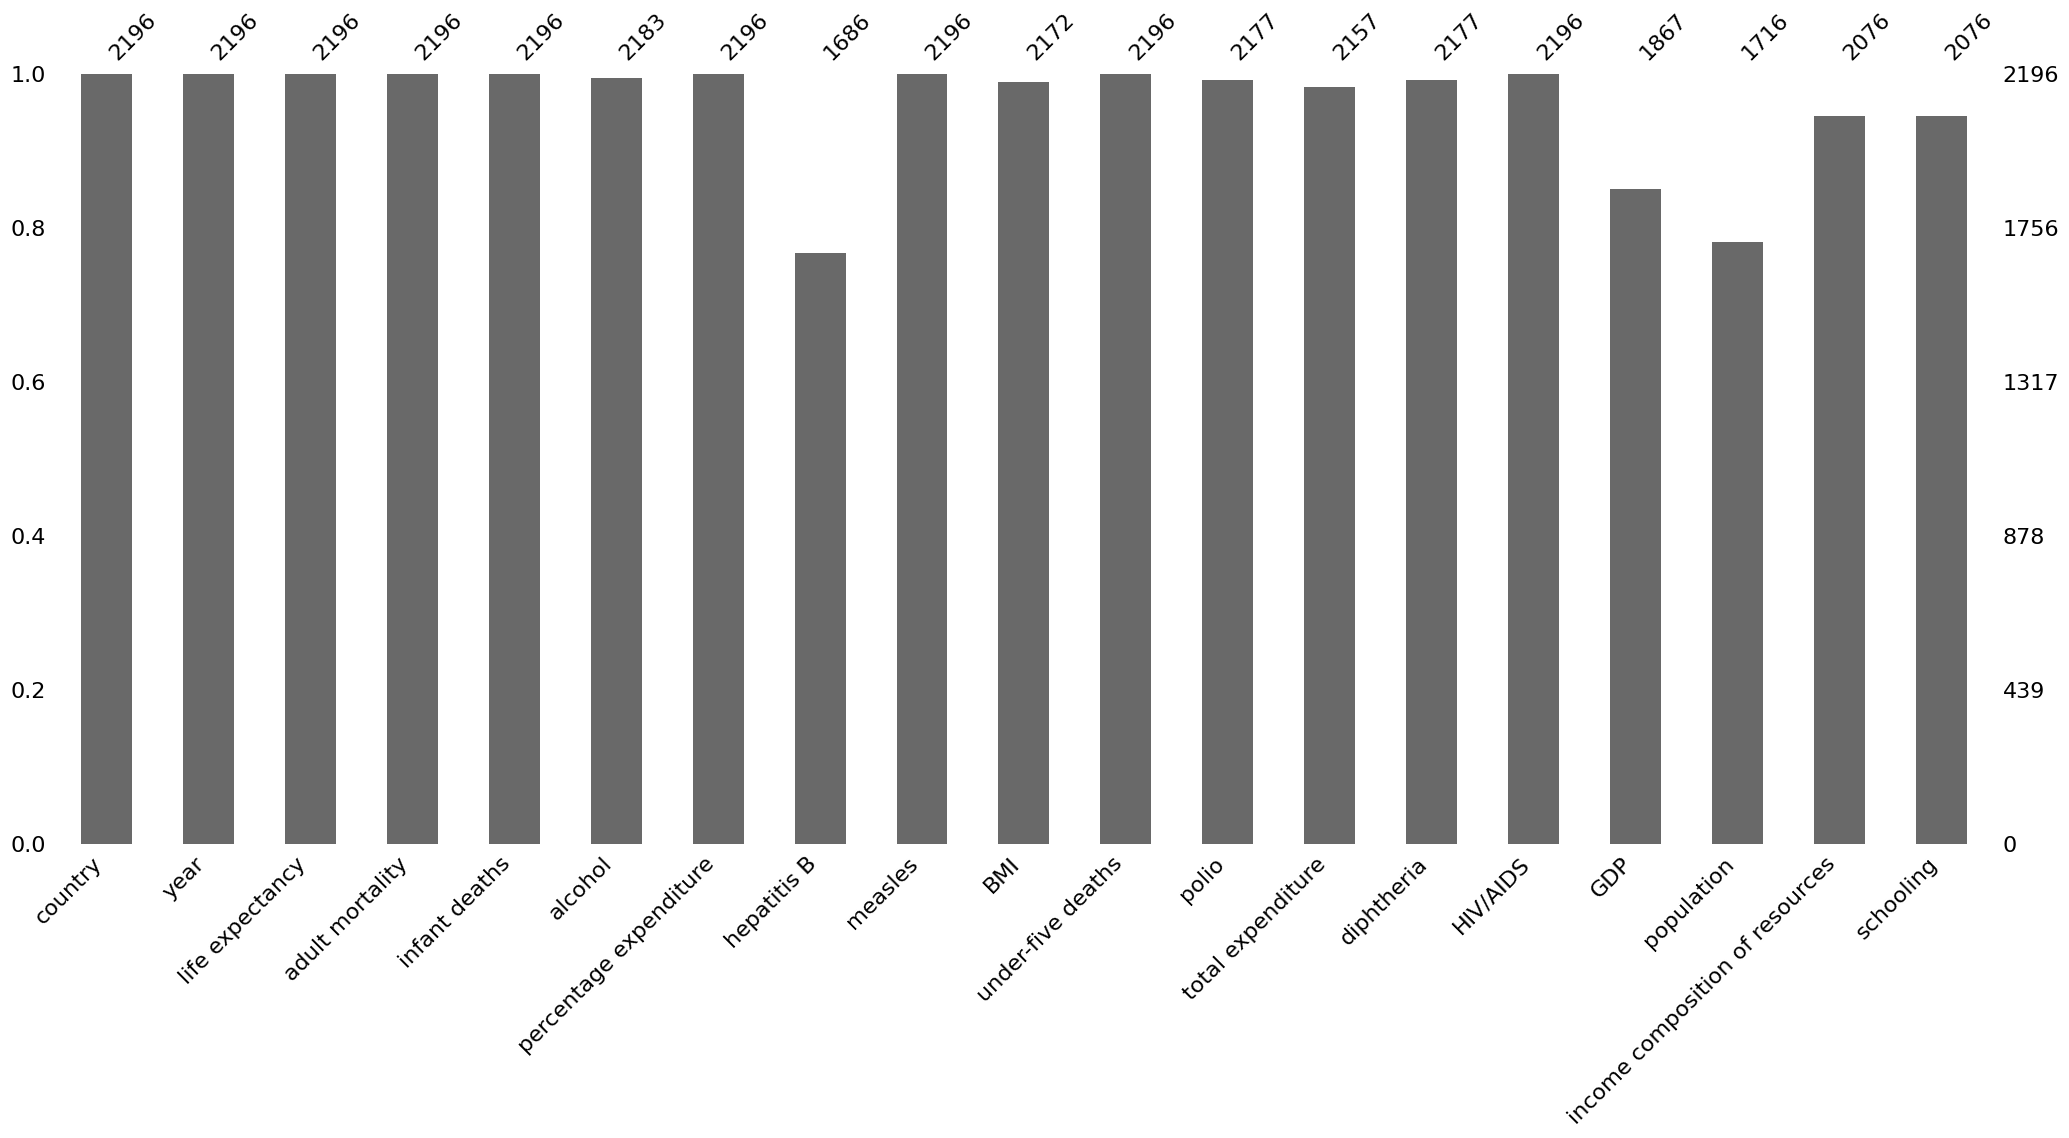

In [166]:
# Выполните визуальный анализ пропущенных значений в обучающей выборке с помощью msno.bar

msno.bar(life_train)

#### [matrix](https://github.com/ResidentMario/missingno?tab=readme-ov-file#matrix)

Визуализация матрицы пропущенных значений с высокой плотностью. Позволяет выявить закономерности заполненности данных. 

<Axes: >

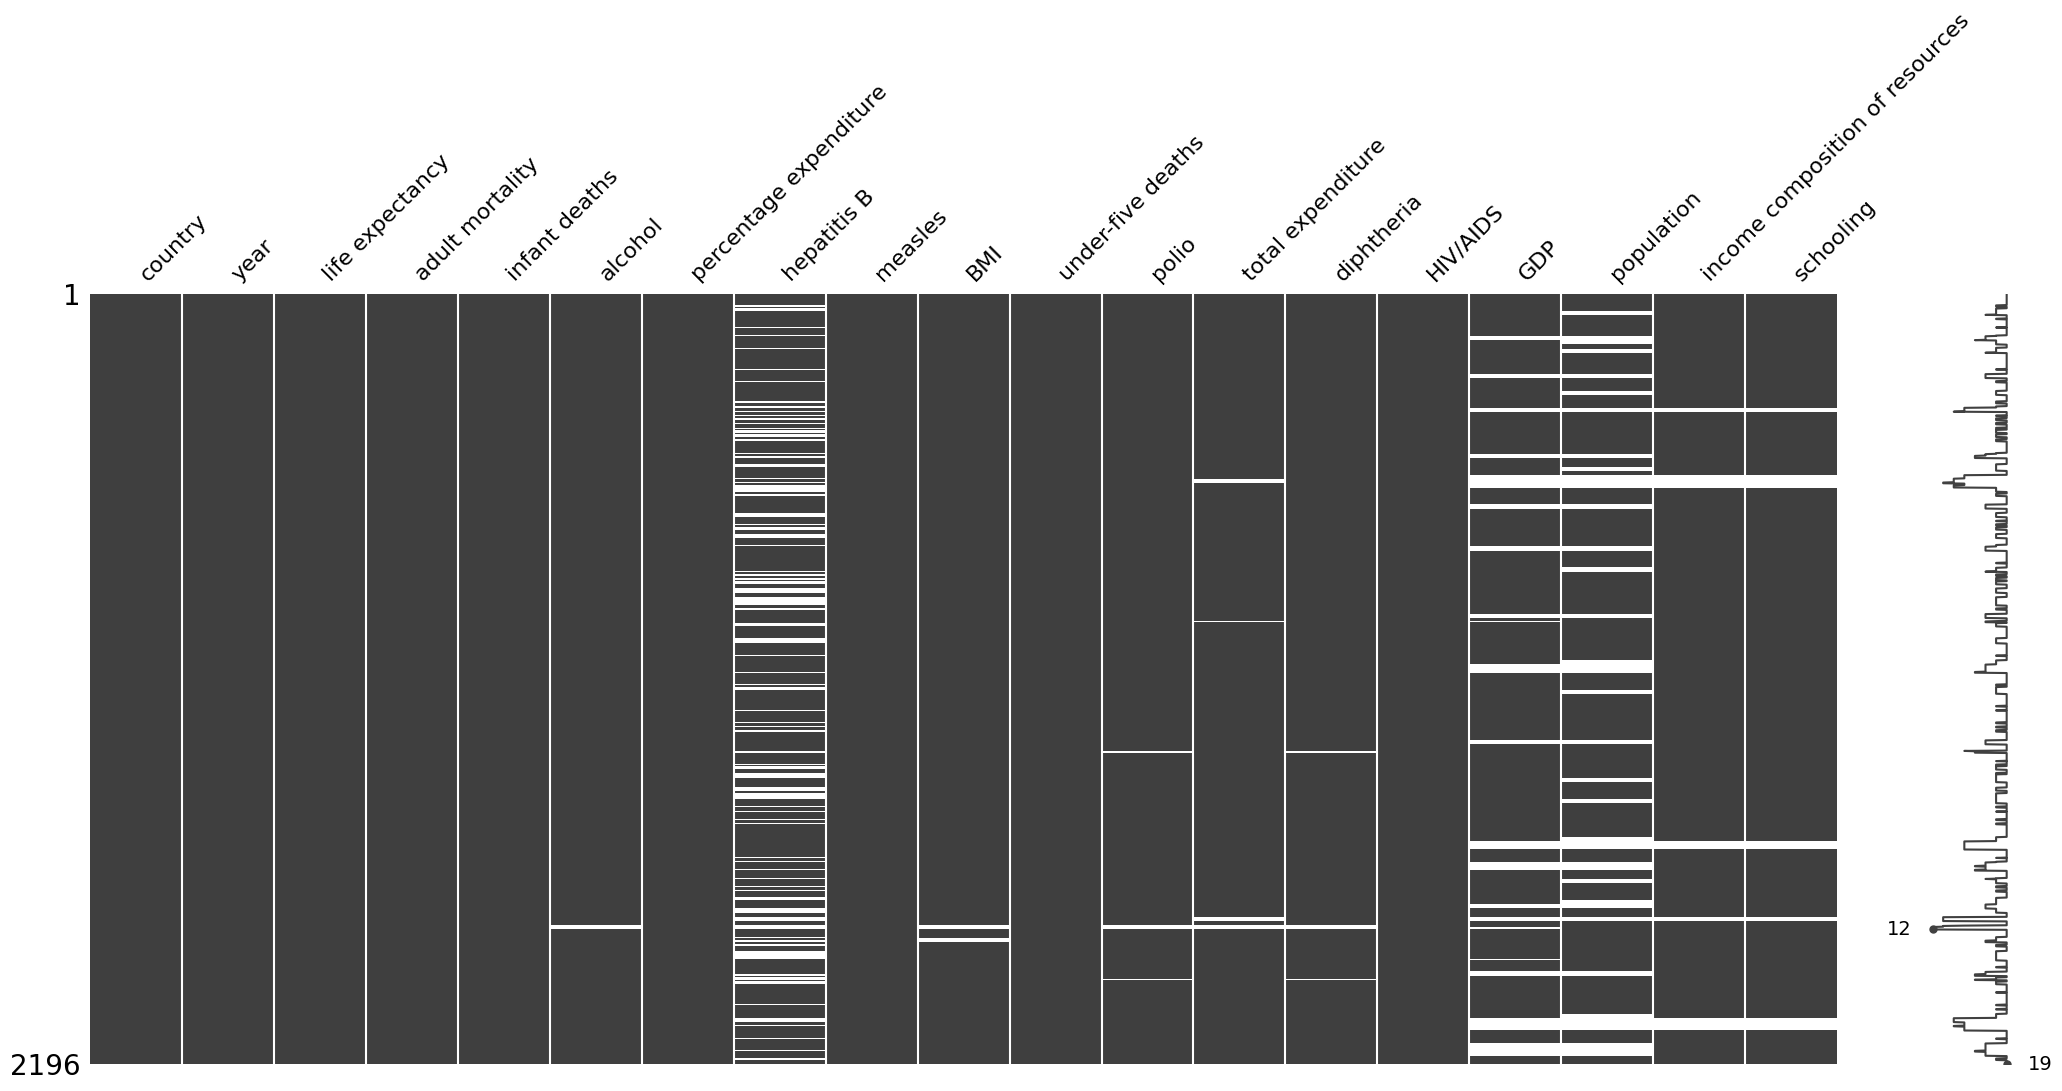

In [167]:
# Выполните визуальный анализ пропущенных значений в обучающей выборке с помощью msno.matrix

msno.matrix(life_train)

#### [heatmap](https://github.com/ResidentMario/missingno?tab=readme-ov-file#heatmap)

Тепловая карта корреляции отсутствующих данных. Показывает, насколько сильно наличие или отсутствие одной переменной связано с наличием другой. Корреляция принимает значения от -1 (переменные противоположны в заполненности) до 1 (одинаковая заполненность).

<Axes: >

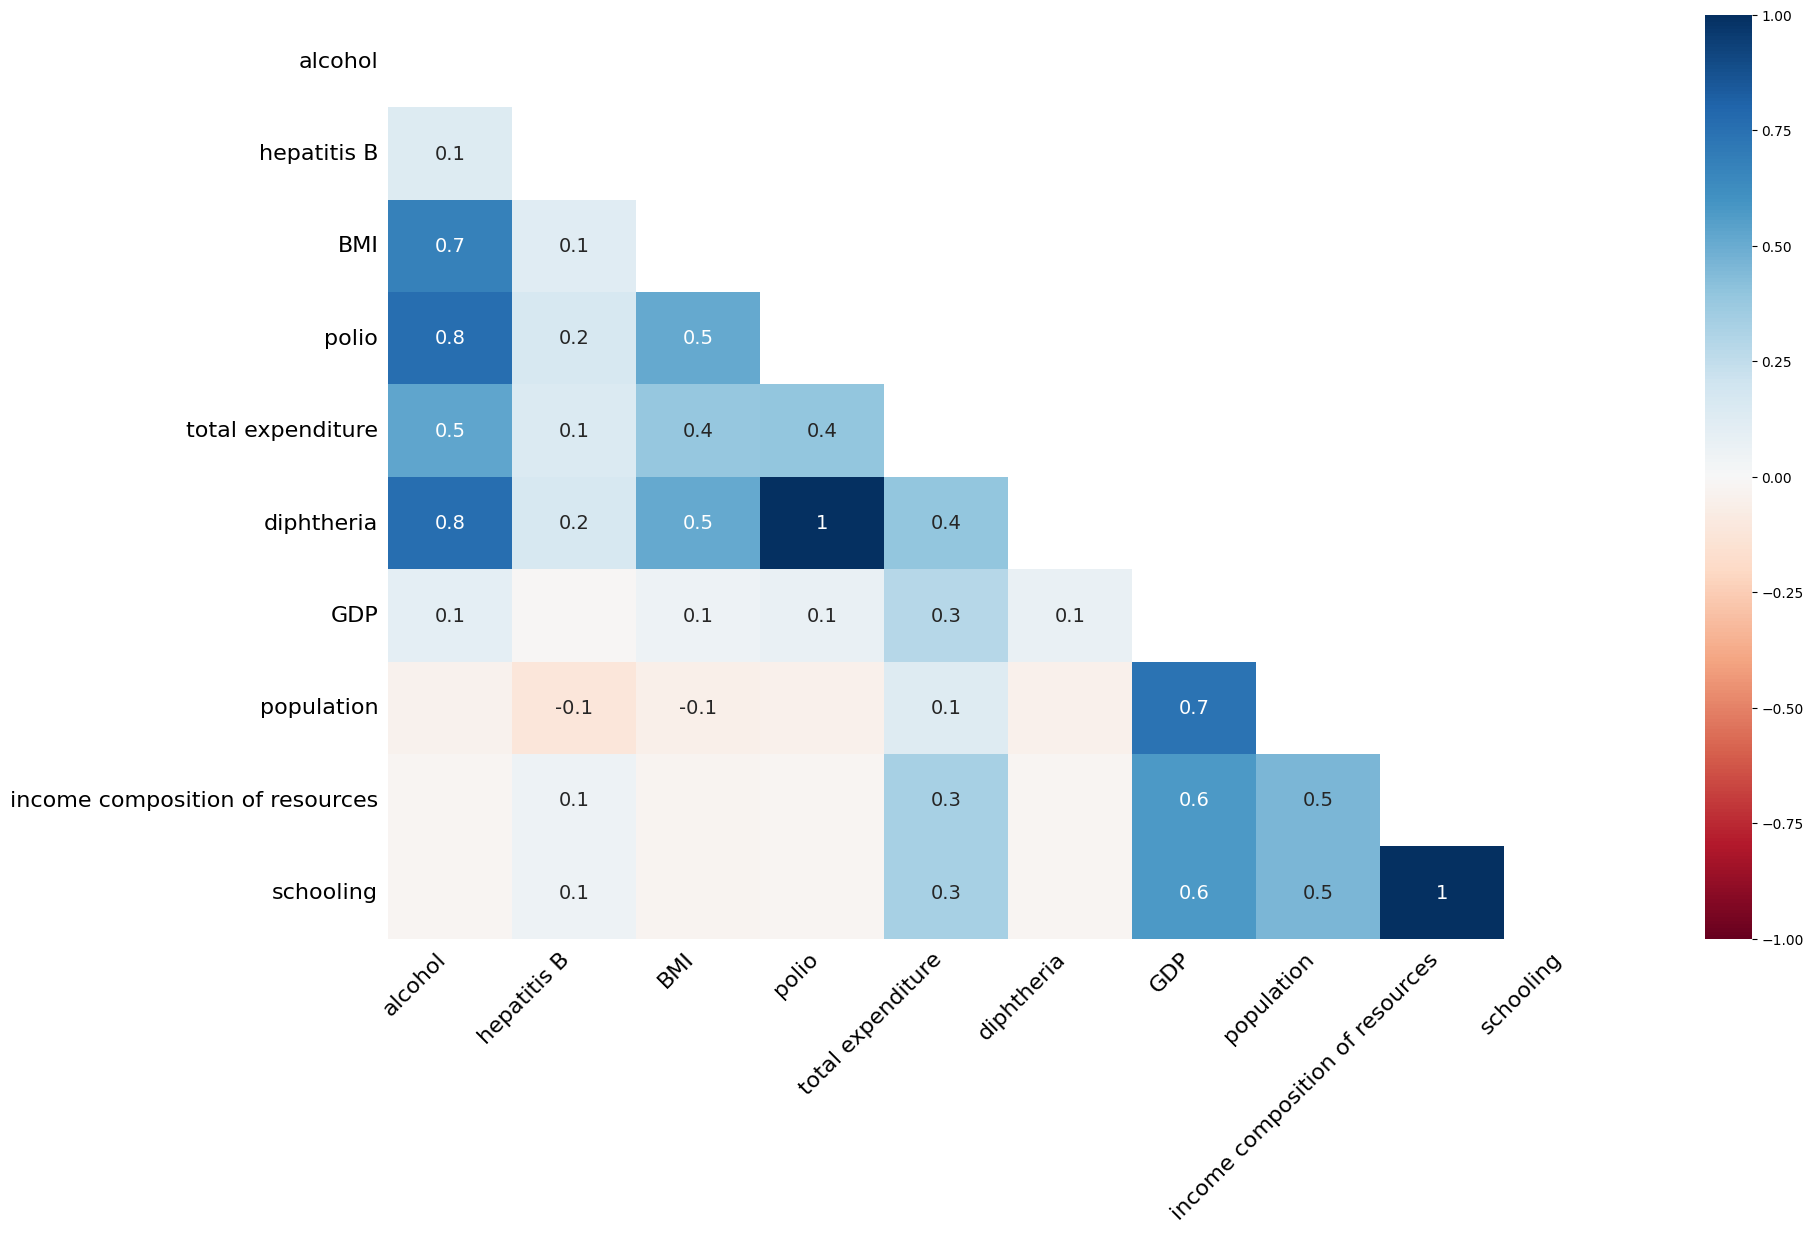

In [168]:
# Выполните визуальный анализ пропущенных значений в обучающей выборке с помощью msno.heatmap

msno.heatmap(life_train)

In [169]:
# Дополните функцию mcar_test

def mcar_test(data, predictor, feature):
    """
    Выполняет статистическую проверку пропущенных значений на принадлежность к типу MCAR.
    Использует t-тест для сравнения распределения feature между группами с пропущенными и существующими значениями predictor.

    Аргументы:
        data (pandas.DataFrame): Датасет с данными для анализа.
        predictor (str): Название столбца в data с пропущенными значениями (целевая переменная для теста MCAR).
        feature (str): Название признака, по которому сравниваются распределения между группами.

    Возвращает:
        float: p-value t-теста.
    """
    data_nans_in_feature = data[data[predictor].isna()]      # Все наблюдения в data с пропусками в predictor
    data_non_nans_in_feature = data[data[predictor].notna()]   # Все наблюдения в data без пропусков в predictor
    _, p_val, _ = ttest_ind(data_nans_in_feature[feature], data_non_nans_in_feature[feature])
    return p_val

In [183]:
# Используя функцию mcar_test, выполните проверку пропущенных значений на принадлежность к типу MCAR
# Используйте только обучающую выборку
# Уровень значимости — 1%

p_values = []

for predictor in life_nan_info.index:
    p_value = mcar_test(life_train, predictor, 'life expectancy')
    p_values.append(p_value.round(6))

life_nan_info['p-value'] = p_values
life_nan_info

,NaN share,p-value
alcohol,0.005920,0.000000
hepatitis B,0.232240,0.000000
BMI,0.010929,0.000000
polio,0.008652,0.000116
total expenditure,0.017760,0.000000
diphtheria,0.008652,0.000116
GDP,0.149818,0.039552
population,0.218579,0.000000
income composition of resources,0.054645,0.007371
schooling,0.054645,0.007371


[]

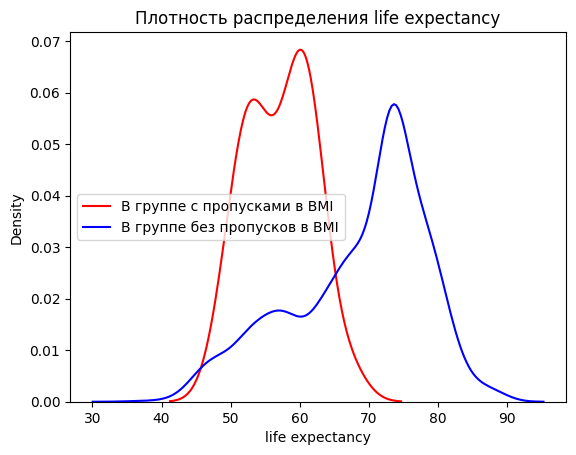

In [171]:
# Визуализируйте плотность целевой переменной
# График позволяет убедиться, что пропуски типов MAR и MNAR зависят от наблюдаемых данных

predictor = 'BMI'
feature = 'life expectancy'

life_train_nans_in_feature = life_train[life_train[predictor].isna()] # Все наблюдения в life_train с пропусками в predictor
life_train_non_nans_in_feature = life_train[life_train[predictor].notna()] # Все наблюдения в life_train без пропусков в predictor

dplt = sns.kdeplot(life_train_nans_in_feature[feature], color='red', label=f'В группе с пропусками в {predictor}')
dplt = sns.kdeplot(life_train_non_nans_in_feature[feature], color='blue', label=f'В группе без пропусков в {predictor}')
dplt.set_title(f'Плотность распределения {feature}')
plt.legend()
plt.plot()

### ***Задание 2***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую и тестовую выборки из задания 1: `life_train`, `life_test`.

* Датасет с результатами анализа пропущенных значений в обучающей выборке из задания 1: `life_nan_info`.

*Для данного задания предположим, что со временем среднее и дисперсия данных не изменились. Это позволит использовать одни и те же StandardScaler, SimpleImputer и KNNImputer для обучающей и тестовой выборок.*

Выполните предобработку данных (см. код задания).

Используя результаты анализа пропущенных значений в обучающей выборке (`life_nan_info`), выполните обработку пропусков **в обучающей выборке** (`life_train`) по следующим правилам:

* Для всех признаков MCAR (если есть):

    * Заполните пропуски средним, обучив SimpleImputer (`life_mean_imputer`).

* Для всех признаков MAR или MNAR (если есть):

    * Если доля пропусков меньше 5%, заполните пропуски средним, обучив SimpleImputer (`life_mean_imputer`).

    * Если доля пропусков больше 5%, заполните пропуски с помощью метода k-ближайших соседей (KNN, K-Nearest Neighbors), обучив KNNImputer (`life_knn_imputer`).

Заполните пропуски в **тестовой выборке**, используя обученные на обучающей выборке SimpleImputer (`life_mean_imputer`) и KNNImputer (`life_knn_imputer`) для соответствующих признаков.

После обработки пропусков обучите модель линейной регрессии без регуляризации `reg_life` и выведите metrics_report на тестовой выборке.

*Pipeline из библиотеки sklearn позволяет использовать SimpleImputer или KNNImputer как трансформатор, то есть как один из этапов предобработки данных в рамках пайплайна*.

In [219]:
# Выделите объясняемый фактор в отдельную переменную

X_life_train, y_life_train = life_train.drop(columns=['life expectancy'], axis=1), life_train['life expectancy']
X_life_test, y_life_test = life_test.drop(columns=['life expectancy'], axis=1), life_test['life expectancy']

In [220]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder
#   train -> fit_transform
#   test -> transform

life_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_life_train_encoded = life_encoder.fit_transform(X_life_train[life_cat_feat])
X_life_test_encoded = life_encoder.transform(X_life_test[life_cat_feat])

In [221]:
# Масштабируйте количественные признаки
#   train -> fit_transform
#   test -> transform

life_scaler = StandardScaler().set_output(transform='pandas')

X_life_train_scaled = life_scaler.fit_transform(X_life_train[life_num_feat])
X_life_test_scaled = life_scaler.transform(X_life_test[life_num_feat])

In [464]:
print('Mean greater than >5% will use life_knn_imputer:')
print(life_nan_info[life_nan_info['NaN share'] > 0.05])
print('\n')
print('Mean less than <5% will use life_mean_imputer:')
print(life_nan_info[life_nan_info['NaN share'] < 0.05])
print('\n')
print('p-value ≥ 0.01 → пропуски MCAR (полностью случайны)')
print(life_nan_info[life_nan_info['p-value'] >= 0.01])

Mean greater than >5% will use life_knn_imputer:
                                 NaN share   p-value
hepatitis B                       0.232240  0.000000
GDP                               0.149818  0.039552
population                        0.218579  0.000000
income composition of resources   0.054645  0.007371
schooling                         0.054645  0.007371


Mean less than <5% will use life_mean_imputer:
                   NaN share   p-value
alcohol             0.005920  0.000000
BMI                 0.010929  0.000000
polio               0.008652  0.000116
total expenditure   0.017760  0.000000
diphtheria          0.008652  0.000116


p-value ≥ 0.01 → пропуски MCAR (полностью случайны)
     NaN share   p-value
GDP   0.149818  0.039552


In [223]:
# Обучите и примените life_mean_imputer (SimpleImputer) к обучающей выборке
#   train -> fit_transform

life_mean_imputer_feat = ['GDP', 'alcohol', 'BMI', 'polio', 'total expenditure', 'diphtheria']

life_mean_imputer = SimpleImputer(strategy='mean')

X_life_train_scaled_imputed = X_life_train_scaled.copy()
X_life_train_scaled_imputed[life_mean_imputer_feat] = life_mean_imputer.fit_transform(
    X_life_train_scaled_imputed[life_mean_imputer_feat]
)

In [224]:
# Обучите и примените life_knn_imputer (KNNImputer) к обучающей выборке
#   train -> fit_transform

life_knn_imputer_feat = ['hepatitis B', 'population', 'income composition of resources', 'schooling']

life_knn_imputer = KNNImputer()

X_life_train_scaled_imputed[life_knn_imputer_feat] = life_knn_imputer.fit_transform(
    X_life_train_scaled_imputed[life_knn_imputer_feat]
)

In [225]:
# Примените life_mean_imputer и life_knn_imputer к тестовой выборке
#   test -> transform

X_life_test_scaled_imputed = X_life_test_scaled.copy()
X_life_test_scaled_imputed[life_mean_imputer_feat] = life_mean_imputer.transform(
    X_life_test_scaled_imputed[life_mean_imputer_feat]
)

X_life_test_scaled_imputed[life_knn_imputer_feat] = life_knn_imputer.transform(
    X_life_test_scaled_imputed[life_knn_imputer_feat]
)

In [229]:
# join all data
X_life_train_encoded_scaled_imputed = X_life_train_scaled_imputed.join(X_life_train_encoded)
X_life_test_encoded_scaled_imputed = X_life_test_scaled_imputed.join(X_life_test_encoded)

In [232]:
print(X_life_train.shape)
print(y_life_train.shape)
print(X_life_test.shape)
print(y_life_test.shape)
print(X_life_train_encoded_scaled_imputed.shape)
print(X_life_test_encoded_scaled_imputed.shape)

(2196, 18)
(2196,)
(732, 18)
(732,)
(2196, 199)
(732, 199)


In [233]:
# Обучите reg_life и выведите metrics_report на тестовой выборке

reg_life = LinearRegression().fit(X_life_train_encoded_scaled_imputed, y_life_train)
y_life_predicted = reg_life.predict(X_life_test_encoded_scaled_imputed)
metrics_report(y_life_test, y_life_predicted)

R2 score: 0.9172
RMSE: 2.4168
MAPE: 0.0236


### **Смещение и разброс**

* **Смещение (Bias)** – ожидаемое отклонение предсказаний модели от истинных значений.

* **Разброс (Variance)** – это ошибка, вызванная чувствительностью модели к небольшим изменениям в обучающих данных.

Смещение и разброс отражают два источника ошибки модели, и между ними существует компромисс: снижение смещения часто ведёт к увеличению разброса, и наоборот. Оптимальная модель должна находить баланс между смещением и разбросом, чтобы минимизировать общую ошибку предсказания.

Для анализа ошибки алгоритма применяется **разложение MSE на смещение и разброс (bias-variance decomposition)**.

Пусть $y$ – истинные значения целевой переменой. Мы предполагаем, что существует функция $f(x)=y+e$, где $e$ – ошибка с $\mathbb{E}[e]=0$ (мат. ожидание) и $\mathbb{D}[e]=\sigma^2$ (дисперсия). $\widehat{f}(x)$ – значения целевой переменной, предсказанные моделью.

Тогда

$$\text{MSE}=\mathbb{E}[(y-\widehat{f}(x))^2]=\text{Bias}^2(\widehat{f}(x))+\text{Variance}(\widehat{f}(x))+\sigma^2$$
где
$$\text{Bias}^2(\widehat{f}(x))=(\mathbb{E}[\widehat{f}(x)]-f(x))^2$$
$$\text{Variance}(\widehat{f}(x))=\mathbb{D}[\widehat{f}(x)]=\mathbb{E}[(\mathbb{E}[\widehat{y}]-\widehat{y})^2]$$
$\sigma^2$ — неустранимая ошибка измерения

Подробнее можно изучить по **ссылкам:**

* [Bias-variance decomposition | education.yandex.ru](https://education.yandex.ru/handbook/ml/article/bias-variance-decomposition).

* [Bias-variance decomposition for classification and regression losses | rasbt.github.io](https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/)

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую и тестовую выборки (после заполнения пропусков) из задания 2: `X_life_train_scaled_imputed`, `X_life_test_scaled_imputed`, `y_life_train`, `y_life_test`.

* Обученную модель из задания 2: `reg_life`.

Обучите две модели линейной регрессии с регуляризацией:

* `lasso_life` — регрессия с L1-регуляризацией (LASSO). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

* `ridge_life` — регрессия с L2-регуляризацией (Ridge). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

Разложите среднеквадратическую ошибку (MSE) каждой из трех обученных моделей (`reg_life`, `lasso_life`, `ridge_life`) на компоненты (функция [bias_variance_decomp](https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/#api)):

* Смещение ($\text{Bias}^2$).

* Разброс ($\text{Variance}$).

In [239]:
# Выполните разложение MSE модели reg_life на смещение и разброс
# Не забудьте зафиксировать RANDOM_STATE

reg_life_mse, reg_life_bias, reg_life_var = bias_variance_decomp(
    estimator=reg_life,
    X_train=X_life_train_encoded_scaled_imputed.values,
    y_train=y_life_train.values,
    X_test=X_life_test_encoded_scaled_imputed.values,
    y_test=y_life_test.values,
    loss='mse', 
    num_rounds=100, 
    random_seed=RANDOM_STATE
)

In [248]:
print("### LinearRegression ###")
print(f"MSE: {reg_life_mse:.4f}")
print(f"Bias^2: {reg_life_bias:.4f}")
print(f"Variance: {reg_life_var:.4f}")

### LinearRegression ###
MSE: 6.4422
Bias^2: 5.9529
Variance: 0.4893


In [243]:
# Обучите модель lasso_life (LASSO)
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

cv_lasso_life = GridSearchCV(
    estimator=Lasso(random_state=RANDOM_STATE)
    , param_grid=params
    , cv=cv
)

lasso_life = cv_lasso_life.fit(X_life_train_encoded_scaled_imputed, y_life_train)

In [244]:
# Выполните разложение MSE модели lasso_life на смещение и разброс
# Не забудьте зафиксировать RANDOM_STATE

lasso_life_mse, lasso_life_bias, lasso_life_var = bias_variance_decomp(
    estimator=lasso_life,
    X_train=X_life_train_encoded_scaled_imputed.values,
    y_train=y_life_train.values,
    X_test=X_life_test_encoded_scaled_imputed.values,
    y_test=y_life_test.values,
    loss='mse', 
    num_rounds=100, 
    random_seed=RANDOM_STATE
)

In [249]:
print("### Lasso ###")
print(f"MSE: {lasso_life_mse:.4f}")
print(f"Bias^2: {lasso_life_bias:.4f}")
print(f"Variance: {lasso_life_var:.4f}")

### Lasso ###
MSE: 7.8895
Bias^2: 7.3632
Variance: 0.5263


In [245]:
# Обучите модель ridge_life (Ridge)
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

cv_ridge_life = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE)
    , param_grid=params
    , cv=cv
)
ridge_life = cv_ridge_life.fit(X_life_train_encoded_scaled_imputed, y_life_train)

In [246]:
# Выполните разложение MSE модели ridge_life на смещение и разброс
# Не забудьте зафиксировать RANDOM_STATE

ridge_life_mse, ridge_life_bias, ridge_life_var = bias_variance_decomp(
    estimator=ridge_life,
    X_train=X_life_train_encoded_scaled_imputed.values,
    y_train=y_life_train.values,
    X_test=X_life_test_encoded_scaled_imputed.values,
    y_test=y_life_test.values,
    loss='mse', 
    num_rounds=100, 
    random_seed=RANDOM_STATE
)

In [250]:
print("### Ridge ###")
print(f"MSE: {ridge_life_mse:.4f}")
print(f"Bias^2: {ridge_life_bias:.4f}")
print(f"Variance: {ridge_life_var:.4f}")

### Ridge ###
MSE: 6.4361
Bias^2: 5.9318
Variance: 0.5043


## **Извлечение признаков из текста**

**Классификация тональности (sentiment analysis)** — это задача определения эмоциональной окраски текста в рамках NLP (Natural Language Processing). 

Как правило, тональность текста делят на три категории:

* Позитивная (к примеру, положительный отзыв).

* Нейтральная (информация без явной эмоциональной окраски).

* Негативная (к примеру, критика или жалоба).

Перед обучением моделей необходимо извлечь признаки из текстовых данных, проведя предобработку текста. 

Основные этапы предобработки текста:

1. Очистка текста от лишних элементов (не влияющих на тональность):

    * Удаление спецсимволов — удаление HTML-тегов, URL, email, хештегов, упоминаний (@user).

    * Удаление цифр — удаление или замена на числительные.

    * Удаление пунктуации.

    * Удаление лишних пробелов и дублирующихся  символов.

2. Токенизация — разбиение текста на отдельные токены (слова, части слов или символы). Пример: 'Я люблю этот фильм!' $\to$ ['Я', 'люблю', 'этот', 'фильм', '!'].

3. Нормализация слов:

    * Лемматизация — приведение слова к лемме — её нормальной (словарной) форме. Пример: 'бежал' $\to$ 'бежать'.

    * Стемминг — выделение основы слова. Пример: 'бежал' $\to$ 'беж'.

4. Удаление стоп-слов — исключение слов, которые часто встречаются в тексте, но не несут значимой смысловой нагрузки для анализа тональности: местоимения, предлоги, союзы, частицы, артикли (для английского) и т.д.

5. Векторизация текста — преобразование текста в числовой формат для обучения и использования моделей машинного обучения:

    * BoW (Bag-of-words).

    * TF-IDF (Term Frequency — Inverse Document Frequency).

    * Векторные эмбеддинги: FastText, Word2Vec, GloVe.

    * Контекстные эмбеддинги: BERT.

*Это лишь основные этапы предобработки текста. На практике количество существующих методов обработки данных больше, а структура и порядок этапов **зависит от задачи***.

Подробнее можно изучить по **ссылкам:**

* [Основы Natural Language Processing для текста | habr.com](https://habr.com/ru/companies/Voximplant/articles/446738/)

* [Преобразование текстовых данных и работа с ними в Python | education.yandex.ru](https://education.yandex.ru/handbook/data-analysis/article/preobrazovanie-tekstovyh-dannyh-i-rabota-s-nimi-v-python)

* [Краткий обзор техник векторизации в NLP | habr.com](https://habr.com/ru/articles/778048/)

* [How to Create Bert Vector Embeddings? A Comprehensive Tutorial | airbyte.com](https://airbyte.com/data-engineering-resources/bert-vector-embedding)

### **TF-IDF**

**TF-IDF** (Term Frequency — Inverse Document Frequency) — это статистическая мера, для оценки важности слова в контексте документа (набора текстовых данных), являющегося частью коллекции или корпуса документов. Высокий вес по TF-IDF получают слова, которые часто встречаются в конкретном документе, но при этом редко встречаются во всех остальных документах корпуса.

Эта мера состоит из двух компонентов:

* TF (Term Frequency — частота слова). TF измеряет, насколько часто слово встречается в конкретном документе. Чем чаще слово появляется в тексте, тем выше его TF. 

$$\text{TF} = \frac{\text{Количество раз, когда слово встретилось в документе}}{\text{Общее количество слов в документе}}$$

* IDF (Inverse Document Frequency — обратная документная частота). IDF измеряет уникальность или информативность слова в масштабах всего корпуса документов. Компонент IDF уменьшает вес слов, которые встречаются слишком часто во многих документах (например, предлоги, союзы). Если слово редкое, его IDF будет высоким.

$$\text{IDF} = \log(\frac{\text{Общее количество документов в корпусе}}{\text{Количество документов, в которых встретилось слово} + 1})$$

Итоговая формула TF-IDF:

$$\text{TF-IDF}=\text{TF} \times \text{IDF}$$

Таким образом, слово получает высокий вес TF-IDF, если оно:

* Часто встречается в данном документе (высокий TF).

* Редко встречается в других документах корпуса (высокий IDF).

TF-IDF позволяет преобразовать наборы текстовых данных в разреженную матрицу признаков, которая может быть использована в алгоритмах машинного обучения.

**Процедура преобразования:**

1. Создание словаря. Составляется полный список всех уникальных слов, которые встретились во всех текстах из корпуса. Каждому уникальному слову присваивается индекс (номер столбца в матрице).

2. Для каждого документа (строки) вычисляется TF-IDF вес каждого слова из словаря. Если слово из общего словаря отсутствует в данном документе, его вес для данного документа будет равен 0.

Итоговая матрица признаков, используемая для обучения моделей ML:

* Строки — документы.

* Столбцы — уникальные слова из всего корпуса документов.

* Значения в ячейках — TF-IDF веса слов.

### ***Задание 4***

Рассмотрим упрощенный пример бинарной классификации тональности текста с помощью логистической регрессии.

Выполните предобработку текстов:

1. Приведите все тексты к нижнему регистру (lowercase). *Подсказка: изучите [векторизованные строковые функции pandas](https://pandas.pydata.org/docs/user_guide/text.html#method-summary).*

2. Очистите тексты от ссылок и лишних символов с помощью функции regex_clean.

3. Дополните функцию `tokenize` и токенизируйте тексты.

4. Дополните функцию `pos_lemmatize` и лемматизируйте тексты c учетом частей речи слов (POS — Part Of Speech). *Подробнее по ссылке: [Lemmatization in NLP | medium.com](https://medium.com/@kevinnjagi83/lemmatization-in-nlp-2a61012c5d66).*

5. Дополните функцию `remove_stop_words` и удалите из текстов стоп-слова.

6. Соберите список лемм (после удаления стоп-слов) в одну строку, отделив леммы знаком пробела. *Подсказка: изучите [векторизованные строковые функции pandas](https://pandas.pydata.org/docs/user_guide/text.html#method-summary).*

7. Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной.

Постройте пайплайн `twit_pipeline`:

1. 'tfidf': [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

2. 'clf': LogisticRegression.

Используя пайплайн `twit_pipeline`, подберите оптимальные гиперпараметры обучения с помощью GridSearchCV **(метрика оптимизации — AUC)**, и с оптимальными гиперпараметрами обучите модель `lr_twit` для бинарной классификации тональности текстов.

Для модели `lr_twit` на тестовой выборке постройте отчет по метрикам классификации и посчитайте метрику AUC.

In [251]:
# Считайте данные

df_twit = pd.read_csv('tweets.csv')
df_twit

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [252]:
# Удалите из датасета нейтральную ('neutral') тональность

df_twit = df_twit[df_twit['sentiment'] != 'neutral']

In [254]:
# Закодируйте целевую переменную:
#   0 — 'negative'
#   1 — 'positive'
# Сбросьте индексы в новом датасете

df_twit['sentiment'] = df_twit['sentiment'].replace({'negative':0, 'positive':1})
df_twit = df_twit.reset_index(drop=True)

In [256]:
# Выведите исходный текст с индексом 1901

print(df_twit.iloc[1901]['text'])

The top 5 words I`ve tweeted: hug, good, people, fun, twitter. http://tinyurl.com/dcxoty ... that`s really quite nice


In [259]:
# Приведите все тексты к нижнему регистру (lowercase)

df_twit['text lowercase'] = df_twit['text'].str.lower()

In [261]:
# Выведите текст с индексом 1901 после приведения к нижнему регистру

print(df_twit.iloc[1901]['text lowercase'])

the top 5 words i`ve tweeted: hug, good, people, fun, twitter. http://tinyurl.com/dcxoty ... that`s really quite nice


In [262]:
def regex_clean(text):
    """
    Очищает текст от ссылок и лишних символов с помощью регулярных выражений.

    Аргументы:
        text (str): Входной текст для очистки.

    Возвращает:
        str: Очищенный текст.
    """
    # Замена всех ссылок в тексте на пробел
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Удаление всех цифр, спецсимволов и знаков пунктуации
    text = re.sub('[0-9!#()$\,\'\-\.*+/:;<=>?@[\]^_`{|}\"]+', ' ', text)

    # Удаление лишних пробелов
    text = re.sub('\s+', ' ', text)
    
    return text

In [264]:
# Очистите тексты от ссылок и лишних символов с помощью функции regex_clean

df_twit['text cleaned'] = df_twit['text lowercase'].apply(regex_clean)

In [267]:
# Выведите текст с индексом 1901 после удаления ссылок и лишних символов

print(df_twit.iloc[1901]['text cleaned'])

the top words i ve tweeted hug good people fun twitter that s really quite nice


In [268]:
# Дополните функцию tokenize

def tokenize(text):
    """
    Токенизирует текст на отдельные слова или токены с использованием NLTK.
    Для токенизации используется функиця word_tokenize.
    
    Аргументы:
        text (str): Входной текст для токенизации.
    
    Возвращает:
        list(str): Список токенов, полученных в результате разбиения текста.
    """
    return word_tokenize(text)

In [270]:
# Токенизируйте тексты с помощью tokenize

df_twit['text tokenized'] = df_twit['text cleaned'].apply(tokenize)

In [272]:
# Выведите текст с индексом 1901 после токенизации

print(df_twit.iloc[1901]['text tokenized'])

['the', 'top', 'words', 'i', 've', 'tweeted', 'hug', 'good', 'people', 'fun', 'twitter', 'that', 's', 'really', 'quite', 'nice']


In [275]:
def treebank_to_wordnet(treebank_pos_tag):
    """
    Преобразует POS-теги из формата Penn Treebank в формат WordNet.
    
    Аргументы:
        treebank_pos_tag (str): POS-тег в формате Penn Treebank.

    Возвращает:
        object: POS-тег в формате WordNet. В случае неизвестного тега по умолчанию возвращает wordnet.NOUN (существительное).
    """
    if treebank_pos_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_pos_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_pos_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [276]:
# Дополните функцию pos_lemmatize

def pos_lemmatize(tokens):
    """
    Лемматизирует список токенов, преобразуя слова к их базовой форме с учетом части речи (POS).
    Для лемматизации используется WordNetLemmatizer.

    Аргументы:
        tokens (list(str)): Список токенов для лемматизации.

    Возвращает:
        list(str): Список лемм, полученных в результате лемматизации токенов.
    """
    lemmatizer = WordNetLemmatizer()

    # Определение POS-тегов в формате Penn Treebank для каждого токена
    pos_tokens = pos_tag(tokens)

    # Лемматизируйте каждый токен с учетом его POS-тега
    # POS-теги в формате Penn Treebank необходимо преобразовать в формат WordNet (используйте функцию treebank_to_wordnet)
    lemmas = [lemmatizer.lemmatize(token, treebank_to_wordnet(pos)) for token, pos in pos_tokens]
    return lemmas

In [277]:
# Лемматизируйте тексты с помощью pos_lemmatize

df_twit['text lemmatized'] = df_twit['text tokenized'].apply(pos_lemmatize)

In [280]:
# Выведите текст с индексом 1901 после лемматизации
print(df_twit.iloc[1901]['text lemmatized'])

['the', 'top', 'word', 'i', 've', 'tweet', 'hug', 'good', 'people', 'fun', 'twitter', 'that', 's', 'really', 'quite', 'nice']


In [286]:
# Дополните функцию remove_stop_words

def remove_stop_words(lemmas, stop_words):
    """
    Удаляет стоп-слова из списка лемм.

    Аргументы:
        lemmas (list(str)): Список лемм.
        stop_words (list(str)): Список стоп-слов для фильтрации.

    Возвращает:
        list(str): Список лемм после удаления стоп-слов.
    """
    lemmas = [item for item in lemmas if item not in stop_words]
    return lemmas

In [287]:
# Удалите стоп-слова из текстов с помощью remove_stop_words
# В качестве списка стоп-слов используйте список из библиотеки NLTK

stop_words = stopwords.words('english')
df_twit['text without stop words'] = df_twit['text lemmatized'].apply(remove_stop_words, stop_words=stop_words)

In [304]:
# Соберите список лемм в одну строку, отделив леммы знаком пробела

df_twit['text preprocessed'] = df_twit['text without stop words'].apply(lambda x: ' '.join(x))

In [305]:
# Выведите текст с индексом 1901 после удаления стоп-слов

print(df_twit.iloc[1901]['text preprocessed'])

top word tweet hug good people fun twitter really quite nice


In [306]:
# Выделите объясняемый фактор в отдельную переменную

X_twit, y_twit = df_twit['text preprocessed'], df_twit['sentiment']

In [308]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_twit_train, X_twit_test, y_twit_train, y_twit_test = train_test_split(X_twit, y_twit,
                                                                        test_size=0.4, 
                                                                        stratify=y_twit, 
                                                                        random_state=RANDOM_STATE)

In [310]:
# Постройте пайплайн twit_pipeline
# Не забудьте зафиксировать RANDOM_STATE

twit_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=RANDOM_STATE))
])

In [312]:
# Обучите модель lr_twit на обучающих данных
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], # (1, 1) — только отдельные слова / (1, 2) — слова и биграммамы (пары слов)
    'tfidf__max_df': [0.9, 0.95],           # Верхний порог частоты слова в корпусе текстов (если частота выше, слово игнорируется)
    'clf__C': [0.001, 0.1, 1.0, 10.0]       # Параметр регуляризации для логистической регрессии
}
scoring = 'roc_auc'
cv = 5

cv_lr_twit = GridSearchCV(
    estimator=twit_pipeline,
    param_grid=params,
    scoring=scoring,
    cv=cv,
    n_jobs=-1                               # Используйте все доступные ядра CPU
).fit(X_twit_train, y_twit_train)

In [314]:
lr_twit = cv_lr_twit.best_estimator_

In [316]:
cv_lr_twit.best_params_

{'clf__C': 10.0, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}

In [318]:
# Постройте отчет по метрикам классификации на тестовой выборке для lr_twit

print(classification_report(y_true=y_twit_test, y_pred=lr_twit.predict(X_twit_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3113
           1       0.87      0.88      0.87      3433

    accuracy                           0.87      6546
   macro avg       0.87      0.86      0.86      6546
weighted avg       0.87      0.87      0.87      6546



In [324]:
# Рассчитайте метрику AUC на тестовой выборке для lr_twit

print(roc_auc_score(y_true=y_twit_test, y_score=lr_twit.predict_proba(X_twit_test)[:, 1]))

0.9385166215664014


### **Извлечение признаков из временных рядов**

Целью извлечения признаков из временных рядов является преобразование исходного временного ряда (последовательности точек во времени) в набор информативных и компактных статических признаков. 

**Основные типы временных признаков:**

* Признаки на основе лагов (предыдущих значений ряда).

    * Лаговые признаки — это значения временного ряда из предыдущих моментов времени.

    * Скользящее среднее (moving average) — среднее значение за несколько предыдущих периодов.

* Признаки на основе даты и времени.

    * Временные компоненты: час, день недели, день месяца, месяц, год и т.д.

    * Бинарные флаги: является ли день выходным, праздничным и т.д.

* Циклические признаки. Чтобы сохранить информацию о цикличности, признаки преобразуют в двумерное пространство с помощью синуса и косинуса. Для признака со значением $x$ и периодом $T$ (например, для часа $T = 24$, для дня недели $T = 7$) создаются два новых признака:

    $$x_{\text{cos}} = \text{cos}(\frac{2 \pi x}{T})$$

    $$x_{\text{sin}} = \text{sin}(\frac{2 \pi x}{T})$$

*Это лишь основные и наиболее простые типы временных признаков. На практике их количество больше, а использование того или иного типа **зависит от решаемой задачи***.

### **Кросс-валидация временных рядов**

Классические методы кросс-валидации не могут быть использованы для временных рядов, упорядоченных во времени. Это связано с проблемой утечки данных (data leakage): случайное перемешивание временного ряда приведет к тому, что модель будет обучаться на данных из будущего, чтобы предсказать прошлое.

Для временных рядов необходимы особые стратегии кросс-валидации, которые сохраняют временной порядок данных.

**[TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)** — это итератор кросс-валидации временных рядов из библиотеки scikit-learn. TimeSeriesSplit реализует подход, известный как кросс-валидация на расширяющемся окне (expanding window cross-validation): c каждой новой итерацией (фолдом) обучающая выборка увеличивается, а валидационная сдвигается вперед во времени.

TimeSeriesSplit может быть использован для подбора гиперпараметров с помощью GridSearchCV. Если **в качестве параметра cv** в GridSearchCV использовать разбиение временного ряда, полученное с помощью TimeSeriesSplit, GridSearchCV будет обучать и валидировать модель на соответствующих разбиениях (фолдах), обеспечивая корректную оценку качества модели.

### **Датасет *Hourly Energy Consumption***

**Для решения задания 5 рассмотрим датасет [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption).**

Набор данных предназначен для анализа и прогнозирования почасового потребления электроэнергии в мегаваттах (MW) в различных регионах, входящих в PJM Interconnection LLC — региональную организацию по передаче электроэнергии в восточной части США. 

Целевая переменная — AEP_MW (количество потребляемой электроэнергии в мегаваттах за каждый час).

Единственная известная переменная датасета — Datetime (временная отметка с точностью до часа, которая указывает дату и время записи).

### ***Задание 5***

Используя значения ряда (AEP_MW), создайте признаки:

* Лаговые признаки (*подсказка: используйте [shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)*):

    * lag 1h — значение AEP_MW 1 час назад (временной лаг в 1 наблюдение). 

    * lag 24h — значение AEP_MW 24 часа назад (временной лаг в 24 наблюдения).

* Скользящее среднее (*подсказка: используйте признак **lag 1h** (скользящее среднее строится по **предыдущим** наблюдениям и не должно включать значение целевой переменной на момент прогноза) и [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)*):

    * mean 24h — среднее AEP_MW за **предыдущие** 24 часа (скользящее среднее по 24 **предыдущим** наблюдениям).

    * mean 7d — среднее AEP_MW за **предыдущие** 7 дней (скользящее среднее по 24 $\times$ 7 **предыдущим** наблюдениям).

Используя метку времени (Datetime), создайте признаки:

* Временные компоненты:

    * hour: час.

    * weekday: день недели.

    * day: число месяца.

    * month: месяц.

    * year: год.

* Бинарные флаги:

    * is_weekend: метка выходного дня (суббота и воскресенье).

* Циклические признаки, закодированные с помощью косинуса и синуса:

    * hour_cos, hour_sin: cos и sin от hour ($T = 24$).

    * day_cos, day_sin: cos и sin от day ($T = 30$).

    * weekday_cos, weekday_sin: cos и sin от weekday ($T = 7$).

    * month_cos, month_sin: cos и sin от month ($T = 12$).

Разделите датасет на обучающую и тестовую выборки так, чтобы в обучающую выборку вошли все данные ранее 2017 года, в тестовую — все данные за 2017 год и позже.

Масштабируйте (стандартизируйте) все признаки на обучающей и тестовой выборке.

**На обучающей выборке** подберите оптимальные гиперпараметры обучения линейной регрессии с L2-регуляризацией (Ridge) с помощью **кросс-валидации временных рядов** (TimeSeriesSplit и GridSearchCV), метрика оптимизации — 'neg_mean_squared_error' (**отрицательный MSE**). Рассчитайте лучшее среднее значение **RMSE** (Root Mean Square Error, среднеквадратическая ошибка) по результатам кросс-валидации. 

Обучите модель Ridge `ridge_aep` с оптимальными гиперпараметрами на всей обучающей выборке и выведите metrics_report **на тестовой выборке**.

*Для данного задания предположим, что со временем среднее и дисперсия данных не изменились. Это позволит использовать один StandardScaler для обучающей и тестовой выборок.*

In [325]:
# Считайте набор данных

df_aep = pd.read_csv('AEP_hourly.csv')
df_aep

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [326]:
# Признак Datetime имеет тип данных object
# Необходимо изменить тип данных для Datetime

df_aep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [327]:
# Измените тип Datetime на datetime64[ns]

df_aep['Datetime'] = pd.to_datetime(df_aep['Datetime'])

In [328]:
# Убедитесь, что тип данных Datetime — datetime64[ns]

df_aep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


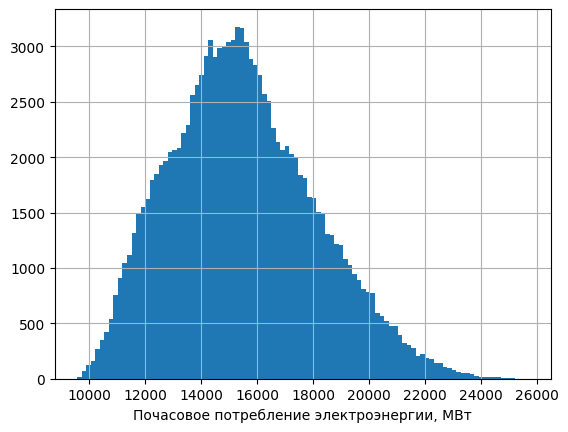

In [330]:
# Постройте гистограмму потребления электроэнергии

df_aep['AEP_MW'].hist(bins=100)
plt.xlabel('Почасовое потребление электроэнергии, МВт')
plt.show()

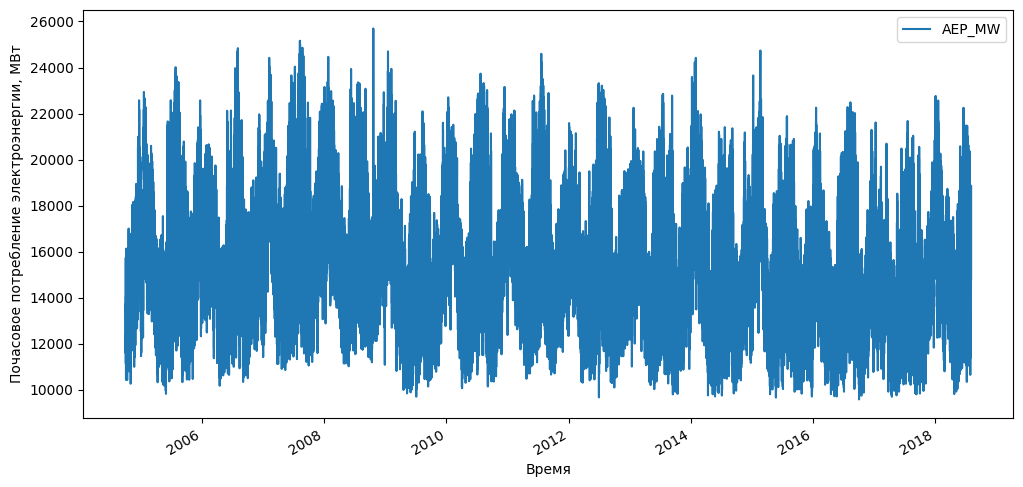

In [331]:
# Постройте график потребления электроэнергии

df_aep.plot(x='Datetime', y='AEP_MW', figsize=(12, 6))
plt.xlabel('Время')
plt.ylabel('Почасовое потребление электроэнергии, МВт')
plt.show()

In [335]:
# Создайте признаки lag 1h и lag 24h
# Подсказка: используйте shift

df_aep['lag 1h'] = df_aep['AEP_MW'].shift(1)
df_aep['lag 24h'] = df_aep['AEP_MW'].shift(24)

In [337]:
# Создайте признаки mean 24h и mean 7d
# Подсказка: используйте признак lag 1h и rolling

df_aep['mean 24h'] = df_aep['lag 1h'].rolling(window=24).mean()
df_aep['mean 7d'] = df_aep['lag 1h'].rolling(window=24*7).mean()

In [339]:
# Закодируйте метку времени (Datetime) как временные компоненты 

df_aep['hour'] = df_aep['Datetime'].dt.hour
df_aep['weekday'] = df_aep['Datetime'].dt.weekday
df_aep['month'] = df_aep['Datetime'].dt.month
df_aep['day'] = df_aep['Datetime'].dt.day
df_aep['year'] = df_aep['Datetime'].dt.year

In [341]:
# Закодируйте метку времени (Datetime) как бинарный флаг is_weekend

df_aep['is_weekend'] = df_aep['Datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [344]:
np.pi

3.141592653589793

In [345]:
# Закодируйте циклические переменные с помощью косинуса и синуса

df_aep['hour_cos'] = np.cos(2 * np.pi * df_aep['hour'] / 24)
df_aep['hour_sin'] = np.sin(2 * np.pi * df_aep['hour'] / 24)

df_aep['day_cos'] = np.cos(2 * np.pi * df_aep['day'] / 30)
df_aep['day_sin'] = np.sin(2 * np.pi * df_aep['day'] / 30)

df_aep['weekday_cos'] = np.cos(2 * np.pi * df_aep['weekday'] / 7)
df_aep['weekday_sin'] = np.sin(2 * np.pi * df_aep['weekday'] / 7)

df_aep['month_cos'] = np.cos(2 * np.pi * df_aep['month'] / 12)
df_aep['month_sin'] = np.sin(2 * np.pi * df_aep['month'] / 12)

In [346]:
# Датасет после создания признаков

df_aep

,Datetime,AEP_MW,lag 1h,lag 24h,mean 24h,mean 7d,hour,weekday,month,day,year,is_weekend,hour_cos,hour_sin,day_cos,day_sin,weekday_cos,weekday_sin,month_cos,month_sin
0,2004-12-31 01:00:00,13478.0,NaN,NaN,NaN,NaN,1,4,12,31,2004,0,0.965926,0.258819,0.978148,0.207912,-0.900969,-0.433884,1.000000,-2.449294e-16
1,2004-12-31 02:00:00,12865.0,13478.0,NaN,NaN,NaN,2,4,12,31,2004,0,0.866025,0.500000,0.978148,0.207912,-0.900969,-0.433884,1.000000,-2.449294e-16
2,2004-12-31 03:00:00,12577.0,12865.0,NaN,NaN,NaN,3,4,12,31,2004,0,0.707107,0.707107,0.978148,0.207912,-0.900969,-0.433884,1.000000,-2.449294e-16
3,2004-12-31 04:00:00,12517.0,12577.0,NaN,NaN,NaN,4,4,12,31,2004,0,0.500000,0.866025,0.978148,0.207912,-0.900969,-0.433884,1.000000,-2.449294e-16
4,2004-12-31 05:00:00,12670.0,12517.0,NaN,NaN,NaN,5,4,12,31,2004,0,0.258819,0.965926,0.978148,0.207912,-0.900969,-0.433884,1.000000,-2.449294e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,20925.0,21971.0,19747.958333,20393.440476,20,0,1,1,2018,0,0.500000,-0.866025,0.978148,0.207912,1.000000,0.000000,0.866025,5.000000e-01
121269,2018-01-01 21:00:00,20999.0,21089.0,21942.0,19711.208333,20407.464286,21,0,1,1,2018,0,0.707107,-0.707107,0.978148,0.207912,1.000000,0.000000,0.866025,5.000000e-01
121270,2018-01-01 22:00:00,20820.0,20999.0,21695.0,19671.916667,20423.065476,22,0,1,1,2018,0,0.866025,-0.500000,0.978148,0.207912,1.000000,0.000000,0.866025,5.000000e-01
121271,2018-01-01 23:00:00,20415.0,20820.0,21230.0,19635.458333,20441.000000,23,0,1,1,2018,0,0.965926,-0.258819,0.978148,0.207912,1.000000,0.000000,0.866025,5.000000e-01


In [347]:
# Удалите строки с пропущенными значениями
# Пропущенные значения появились после создания лаговых признаков и скользящих средних

df_aep = df_aep.dropna()

In [350]:
# Выделите объясняемый фактор в отдельную переменную
# Также удалите метку времени (Datetime) из объясняющих переменных

X_aep, y_aep = df_aep.drop(columns=['Datetime', 'AEP_MW']), df_aep['AEP_MW']

In [363]:
# Разделите датасет на обучающую и тестовую выборки:
#   Обучающая выборка — все данные ранее 2017 года
#   Тестовая выборка  — все данные за 2017 год и позже

X_aep_train = X_aep[X_aep['year'] < 2017]
y_aep_train = y_aep[X_aep['year'] < 2017]

X_aep_test = X_aep[X_aep['year'] >= 2017]
y_aep_test = y_aep[X_aep['year'] >= 2017]

In [364]:
# Масштабируйте все признаки
#   train -> fit_transform
#   test -> transform

aep_scaler = StandardScaler().set_output(transform='pandas')

X_aep_train_scaled = aep_scaler.fit_transform(X_aep_train)
X_aep_test_scaled = aep_scaler.transform(X_aep_test)

In [365]:
# На обучающей выборке подберите оптимальные гиперпараметры обучения Ridge с помощью кросс-валидации временных рядов
# Используйте TimeSeriesSplit и GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}
scoring = 'neg_mean_squared_error'
cv = 10

tscv = TimeSeriesSplit(n_splits=cv)

cv_ridge_aep = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=params,
    scoring=scoring,
    cv=tscv,
    n_jobs=-1
).fit(X_aep_train_scaled, y_aep_train)

In [372]:
# Рассчитайте лучшее среднее значение RMSE по результатам кросс-валидации

best_rmse = np.sqrt(-cv_ridge_aep.best_score_)
print("Лучший средний RMSE (по кросс-валидации):", best_rmse)

Лучший средний RMSE (по кросс-валидации): 490.3590158849941


In [377]:
# Обучите ridge_aep с оптимальными гиперпараметрами на всей обучающей выборке и выведите metrics_report на тестовой выборке

ridge_aep = cv_ridge_aep.best_estimator_
ridge_aep.fit(X_aep_train_scaled, y_aep_train)
y_aep_pred = ridge_aep.predict(X_aep_test_scaled)

metrics_report(y_true=y_aep_test, y_pred=y_aep_pred)

R2 score: 0.9630
RMSE: 462.4050
MAPE: 0.0226


### **Отбор признаков**

**Отбор признаков** (feature selection) — это процесс выбора наиболее информативных переменных из исходного набора данных. Такой подход позволяет упростить модель, сократить время обучения, повысить точность и уменьшить переобучение. Существует три основные группы методов: фильтры, обёртки и встроенные методы.

**Фильтры (filter methods)** 

Фильтры оценивают важность признаков на основе статистических критериев независимо от используемой модели машинного обучения. Признаки оцениваются по отдельности, а затем выбирается подмножество признаков, которые лучше всего коррелируют с целевой переменной.

Такие методы просты в реализации и быстры, но не учитывают взаимодействие между признаками и специфику модели. 

Примеры методов: 

* Корреляционный анализ.

* Критерий $\chi^2$ (хи-квадрат).

* ANOVA F-тест.

**Обёртки (wrapper methods)**

Обёртки используют модели для оценки качества различных подмножеств признаков. Эти методы перебирают различные комбинации признаков, обучают модель и сравнивают качество прогнозов.

Такие методы способны учитывать взаимодействие признаков и специфику модели, но вычислительно затратны.

Примеры методов:

* SFS (Sequential Forward Selection). Отбор начинается с пустого множества признаков. На каждом шаге к текущему набору добавляется тот признак, который при включении даёт наибольшее улучшение качества модели. Процесс продолжается до тех пор, когда не будет достигнут заданный размер подмножества или когда дальнейшее добавление признаков не будет улучшать качество.

* SBS (Sequential Backward Selection). Отбор начинается со всех признаков. На каждом шаге удаляется тот признак, чьё исключение меньше всего ухудшает качество модели. Процесс повторяется, пока не останется заданное число признаков.

* RFE (Recursive Feature Elimination). Отбор осуществляется на основе коэффициентов или важности признаков в обученной модели путем удаления наименее значимого признака. Процесс повторяется рекурсивно, пока не останется заданное количество признаков.

**Встроенные методы (embedded methods)**

Встроенные методы производят отбор признаков непосредственно в процессе обучения модели: используются внутренние механизмы модели для определения важности признаков. 

Встроенные методы сочетают преимущества фильтрующих (скорость) и оберточных (учет специфики модели) методов. 

Примеры методов: 

* L1-регуляризация (LASSO) для линейных моделей.

* Feature Importance в деревьях решений и ансамблевых методах (Random Forest, Gradient Boosting).

*На практике перечисленные методы могут комбинироваться. Например, сначала с помощью фильтра убираются малоинформативные признаки, а затем применяется обёртка для более точного отбора признаков.*

Подробнее можно изучить по **ссылкам:**

* [Comprehensive Guide on Feature Selection | kaggle.com](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection)

* [Отбор признаков (Feature selection) | scikit-learn.ru](https://scikit-learn.ru/stable/modules/feature_selection.html#univariate-feature-selection)

### **Датасет *Company Bankruptcy Prediction***

**Для решения задания 6 рассмотрим датасет [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction).**

**ВНИМАНИЕ:** При решении задания **используйте файл bankruptcy.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Набор данных предназначен для выявления компаний с высоким риском банкротства на основе их финансовых показателей. Данные были собраны из базы данных компании Taiwan Economic Journal за период с 1999 по 2009 годы.

Целевая переменная — Bankrupt? (банкротство компании):

0 — в течение рассматриваемого периода компания работала без признаков банкротства.

1 — компания обанкротилась в течение рассматриваемого периода.

В датасете содержатся 95 различных показателей финансового состояния компаний, значения которых были предварительно стандартизированы.

Одной из особенностей набора данных является дисбаланс классов в целевой переменной: только 3.22% от числа компаний в выборке были признаны банкротами за указанный период. 

### ***Задание 6***

Используя все признаки, обучите baseline модель логистической регрессии (LogisticRegression) `lr_bankr_baseline` с параметрами:

* solver='liblinear' — алгоритм оптимизации, который поддерживает L1 и L2 регуляризации.

* class_weight='balanced' — корректировка веса классов обратно пропорционально их частотам в обучающем наборе данных.

* random_state=RANDOM_STATE.

*Baseline — это базовая модель, которая используется как отправная точка для оценки и сравнения более продвинутых моделей в задачах машинного обучения.*

Выполните отбор признаков тремя методами и обучите модели на оптимальном наборе признаков:

* **Фильтр: ANOVA F-тест (SelectKBest).**

    1. Постройте пайплайн `bankr_kbest_pipeline`:

        1. 'selector': [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)) — выбирает k лучших признаков на основе оценки ANOVA F-теста.

        2. 'clf': LogisticRegression с теми же параметрами, что и baseline модель.

    2. С помощью GridSearchCV и пайплайна `bankr_kbest_pipeline` подберите на обучающей выборке оптимальное количество признаков $k_{\text{KBest}}$, где $k_{\text{KBest}}$ — число от 1 до 40.

    3. На оптимальном наборе из $k_{\text{KBest}}$ признаков на всей обучающей выборке обучите модель (пайплайн) `lr_bankr_kbest` с теми же параметрами, что и baseline модель.

* **Обёртка: SFS (SequentialFeatureSelector).**

    1. Используя [SequentialFeatureSelector](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector) из библиотеки mlxtend, подберите на обучающей выборке оптимальный набор из $k_{\text{SFS}}$ признаков, где $k_{\text{SFS}}$ — число от 1 до 40.

    2. На оптимальном наборе из $k_{\text{SFS}}$ признаков на всей обучающей выборке обучите модель `lr_bankr_sfs` с теми же параметрами, что и baseline модель.

* **Встроенный метод: L1 регуляризация.**

    1. С помощью GridSearchCV подберите на обучающей выборке значение оптимального гиперпараметра регуляризации C для **логистической регрессии с L1 регуляризацией** (остальные параметры те же, что и в baseline модели).

    2. На всей обучающей выборке обучите модель с L1 регуляризацией `lr_bankr_l1`, в качестве параметров используя оптимальный гиперпараметр регуляризации и те же параметры, что и в baseline модели.

Для обученных моделей `lr_bankr_kbest`, `lr_bankr_sfs` и `lr_bankr_l1` определите количество отобранных признаков k.

На тестовой выборке для всех моделей, включая baseline (`lr_bankr`, `lr_bankr_kbest`, `lr_bankr_sfs` и `lr_bankr_l1`), постройте  отчёты по метрикам классификации, рассчитайте метрики f1 и AUC.

In [378]:
# Считайте данные

df_bankr = pd.read_csv('bankruptcy.csv')
df_bankr

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [379]:
# Всего в датасете 95 признаков (без учета целевой переменной)
# Пропущенные значения отсутствуют 

df_bankr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [380]:
# В датасете присутствует дисбаланс классов

df_bankr['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [387]:
# Выделите объясняемый фактор в отдельную переменную

X_bankr, y_bankr = df_bankr.drop(columns=['Bankrupt?']), df_bankr['Bankrupt?']

In [388]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_bankr_train, X_bankr_test, y_bankr_train, y_bankr_test = train_test_split(X_bankr, y_bankr,
                                                                            test_size=0.4, stratify=y_bankr,
                                                                            random_state=RANDOM_STATE)

In [410]:
# Обучите baseline модель lr_bankr_baseline
# Не забудьте зафиксировать RANDOM_STATE

lr_bankr_baseline = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
lr_bankr_baseline.fit(X_bankr_train, y_bankr_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [411]:
# Постройте отчет по метрикам классификации для модели lr_bankr на тестовой выборке
print(classification_report(y_bankr_test, lr_bankr_baseline.predict(X_bankr_test)))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      2640
           1       0.05      0.35      0.09        88

    accuracy                           0.78      2728
   macro avg       0.51      0.57      0.49      2728
weighted avg       0.94      0.78      0.85      2728



In [412]:
# Посчитайте f1 для модели lr_bankr_baseline на тестовой выборке
print(f1_score(y_bankr_test, lr_bankr_baseline.predict(X_bankr_test)))

0.09494640122511486


In [418]:
# Посчитайте AUC для модели lr_bankr_baseline на тестовой выборке
print(roc_auc_score(y_bankr_test, lr_bankr_baseline.predict_proba(X_bankr_test)[:, 1]))

0.6402935606060605


In [399]:
# Постройте пайплайн bankr_kbest_pipeline (см. задание)
# Не забудьте зафиксировать RANDOM_STATE

bankr_kbest_pipeline = Pipeline([
    ('selector', SelectKBest(f_classif)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'))
])

In [400]:
# С помощью GridSearchCV и bankr_kbest_pipeline подберите на обучающей выборке оптимальное количество признаков

params = {
    'selector__k': range(1, 40)
}
scoring = 'f1'
cv = 5

cv_lr_bankr_kbest = GridSearchCV(
    estimator=bankr_kbest_pipeline, 
    param_grid=params,
    scoring=scoring,
    cv=cv, 
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [404]:
# Выведите оптимальное количество признаков для bankr_kbest_pipeline

cv_lr_bankr_kbest.best_params_

{'selector__k': 7}

In [419]:
# На наборе из оптимального числа признаков на всей обучающей выборке обучите модель lr_bankr_kbest

lr_bankr_kbest = cv_lr_bankr_kbest.best_estimator_.fit(X_bankr_train, y_bankr_train)

In [420]:
# Постройте отчет по метрикам классификации для модели lr_bankr_kbest на тестовой выборке

print(classification_report(y_bankr_test, lr_bankr_kbest.predict(X_bankr_test)))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2640
           1       0.16      0.86      0.27        88

    accuracy                           0.85      2728
   macro avg       0.58      0.85      0.59      2728
weighted avg       0.97      0.85      0.89      2728



In [421]:
# Посчитайте f1 для модели lr_bankr_kbest на тестовой выборке

print(f1_score(y_bankr_test, lr_bankr_kbest.predict(X_bankr_test)))

0.26527050610820246


In [423]:
# Посчитайте AUC для модели lr_bankr_kbest на тестовой выборке

print(roc_auc_score(y_bankr_test, lr_bankr_kbest.predict_proba(X_bankr_test)[:, 1]))

0.927961432506887


In [424]:
# Используя SequentialFeatureSelector, подберите на обучающей выборке оптимальный набор признаков
# Не забудьте зафиксировать RANDOM_STATE

bankr_sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'), 
    k_features=(1, 40), 
    forward=True, 
    floating=False,
    scoring='f1',
    cv=5,
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [428]:
# Выведите оптимальное количество признаков после SFS
print('Кол-во признаков после SFS', len(bankr_sfs.k_feature_idx_))
bankr_sfs.k_feature_idx_

Кол-во признаков после SFS 9


(7, 27, 30, 40, 64, 68, 72, 89, 91)

In [436]:
# Создайте новые выборки с оптимальными признаками после SFS
name_of_columns_sfs = X_bankr_train.columns[list(bankr_sfs.k_feature_idx_)]
X_bankr_train_sfs = X_bankr_train[name_of_columns_sfs]
X_bankr_test_sfs = X_bankr_test[name_of_columns_sfs]

In [440]:
# На оптимальном наборе признаков на всей обучающей выборке обучите модель lr_bankr_sfs
# Не забудьте зафиксировать RANDOM_STATE

lr_bankr_sfs = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', 
                                  class_weight='balanced').fit(X_bankr_train_sfs, y_bankr_train)

In [444]:
# Постройте отчет по метрикам классификации для модели lr_bankr_sfs на тестовой выборке

print(classification_report(y_bankr_test, lr_bankr_sfs.predict(X_bankr_test_sfs)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2640
           1       0.35      0.42      0.38        88

    accuracy                           0.96      2728
   macro avg       0.66      0.70      0.68      2728
weighted avg       0.96      0.96      0.96      2728



In [445]:
# Посчитайте f1 для модели lr_bankr_sfs на тестовой выборке

print(f1_score(y_bankr_test, lr_bankr_sfs.predict(X_bankr_test_sfs)))

0.37948717948717947


In [446]:
# Посчитайте AUC для модели lr_bankr_sfs на тестовой выборке

print(roc_auc_score(y_bankr_test, lr_bankr_sfs.predict_proba(X_bankr_test_sfs)[:, 1]))

0.82170282369146


In [448]:
# С помощью GridSearchCV подберите на обучающей выборке значение оптимального гиперпараметра регуляризации C
# Не забудьте зафиксировать RANDOM_STATE

estimator = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, penalty='l1')
params = {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
cv = 5
scoring = 'f1'

cv_lr_bankr_l1 = GridSearchCV(
    estimator=estimator
    , cv=cv
    , scoring=scoring
    , n_jobs=-1
    , param_grid=params
).fit(X_bankr_train, y_bankr_train)

In [452]:
# На всей обучающей выборке обучите модель с L1 регуляризацией lr_bankr_l1
# Не забудьте зафиксировать RANDOM_STATE

lr_bankr_l1 = cv_lr_bankr_l1.best_estimator_.fit(X_bankr_train, y_bankr_train)

In [460]:
# Выведите количество отобранных признаков (признаков, регрессионный коэффициент при которых не равен 0) в lr_bankr_l1

# получаем массив коэффициентов
coefs = lr_bankr_l1.coef_[0]

# считаем количество ненулевых коэффициентов
n_selected_features = np.sum(coefs != 0)
print("Количество отобранных признаков:", n_selected_features)

Количество отобранных признаков: 29


In [461]:
# Постройте отчет по метрикам классификации для модели lr_bankr_l1 на тестовой выборке

print(classification_report(y_bankr_test, lr_bankr_l1.predict(X_bankr_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2640
           1       0.16      0.81      0.27        88

    accuracy                           0.86      2728
   macro avg       0.58      0.83      0.60      2728
weighted avg       0.97      0.86      0.90      2728



In [462]:
# Посчитайте f1 для модели lr_bankr_l1 на тестовой выборке

print(f1_score(y_bankr_test, lr_bankr_l1.predict(X_bankr_test)))

0.27099236641221375


In [463]:
# Посчитайте AUC для модели lr_bankr_l1 на тестовой выборке

print(roc_auc_score(y_bankr_test, lr_bankr_l1.predict_proba(X_bankr_test)[:, 1]))

0.9116606404958678
